# Capstone Project Part 5: Baseline Models Pre-Tokenizing

**Authur:** Kate Meredith 

**Date:** September-November 2022

**Notebook #**: 5 of

## Background

**Source:** Data was collected from [CoffeeReview.com](https://www.coffeereview.com/) and grouped into two DataFrames for cleaning. See prior notebooks for details on scraping, cleaning and compilation.

**Goal:** Run initial models using numeric data that does not require tokenizing as a baseline.

## References

In [100]:
#Importing libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.neural_network import MLPRegressor
from tensorflow.keras.callbacks import EarlyStopping

## Importing Data and EDA

In [4]:
#importing data
coffee = pd.read_csv('coffee.csv')

In [5]:
#overview of df
coffee.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6557 entries, 0 to 6556
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   coffee_name    6557 non-null   object 
 1   roaster_name   6557 non-null   object 
 2   month          6557 non-null   int64  
 3   year           6557 non-null   int64  
 4   bean_agtron    6557 non-null   int64  
 5   ground_agtron  6557 non-null   int64  
 6   aroma          6557 non-null   int64  
 7   acidity        6557 non-null   int64  
 8   body           6557 non-null   int64  
 9   flavor         6557 non-null   int64  
 10  aftertaste     6557 non-null   int64  
 11  roaster_lat    6557 non-null   float64
 12  roaster_lon    6557 non-null   float64
 13  origin_lat     6557 non-null   float64
 14  origin_lon     6557 non-null   float64
 15  p1             6557 non-null   object 
 16  p2             6557 non-null   object 
 17  p3             6557 non-null   object 
 18  overall_

In [6]:
#checking nan
coffee.isnull().sum()

coffee_name      0
roaster_name     0
month            0
year             0
bean_agtron      0
ground_agtron    0
aroma            0
acidity          0
body             0
flavor           0
aftertaste       0
roaster_lat      0
roaster_lon      0
origin_lat       0
origin_lon       0
p1               0
p2               0
p3               0
overall_score    0
dtype: int64

Creating numeric only df to run initial models from:

In [7]:
numeric_df = coffee.filter(['month','year','bean_agtron','ground_agtron','aroma','acidity','body','flavor','aftertaste','roaster_lat','roaster_lon','origin_lat','origin_lon','overall_score'], axis = 1)

In [8]:
#previewing numeric dataframe
numeric_df.head()

,month,year,bean_agtron,ground_agtron,aroma,acidity,body,flavor,aftertaste,roaster_lat,roaster_lon,origin_lat,origin_lon,overall_score
0,10,2022,60,77,9,9,9,9,8,37.973535,-122.531087,4.099917,-72.908813,94
1,10,2022,58,78,9,9,9,9,8,33.448437,-112.074141,-6.869970,-75.045851,94
2,10,2022,59,77,9,9,8,9,8,33.448437,-112.074141,4.099917,-72.908813,93
3,10,2022,62,78,8,8,9,9,8,37.973535,-122.531087,12.609016,-85.293691,92
4,10,2022,65,81,9,9,8,9,8,25.072134,121.679919,10.211670,38.652120,93


Plotting numeric value histograms to get sense of distribution. Code based on clustering codealong.

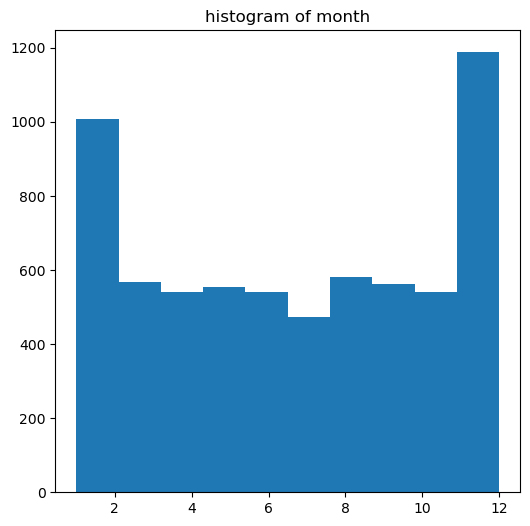

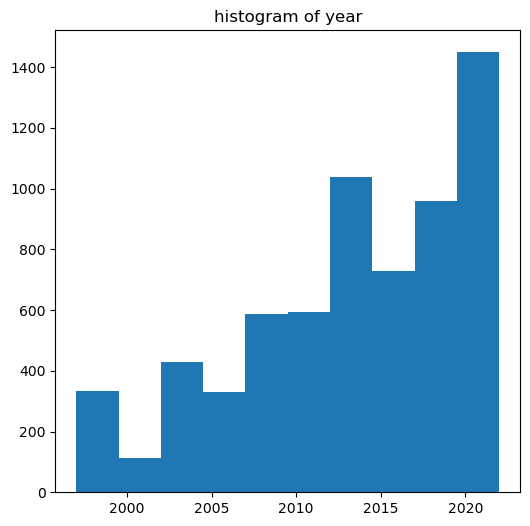

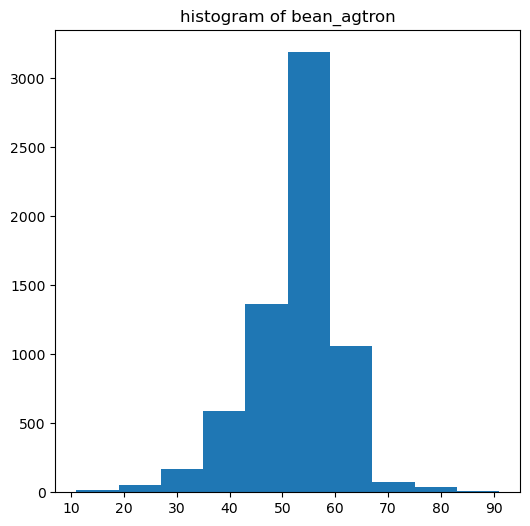

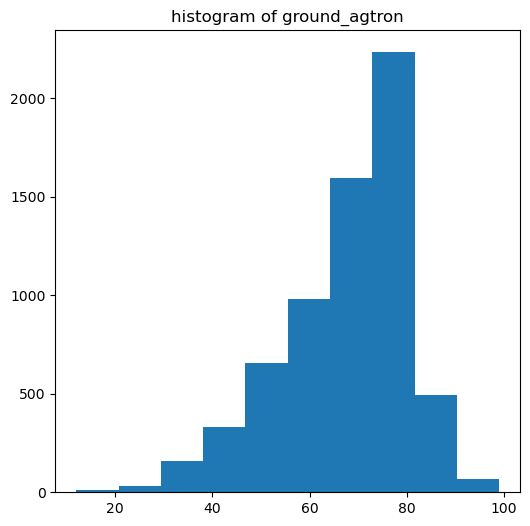

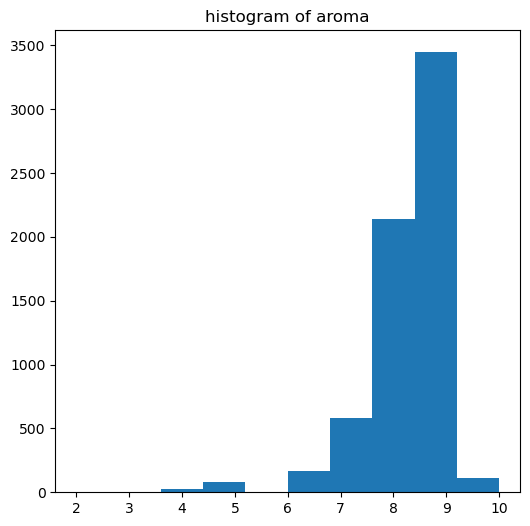

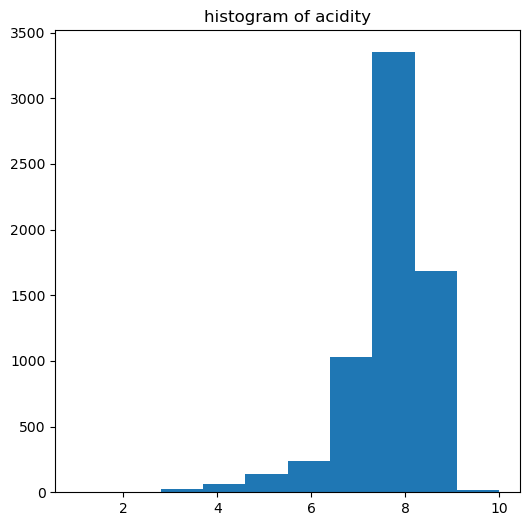

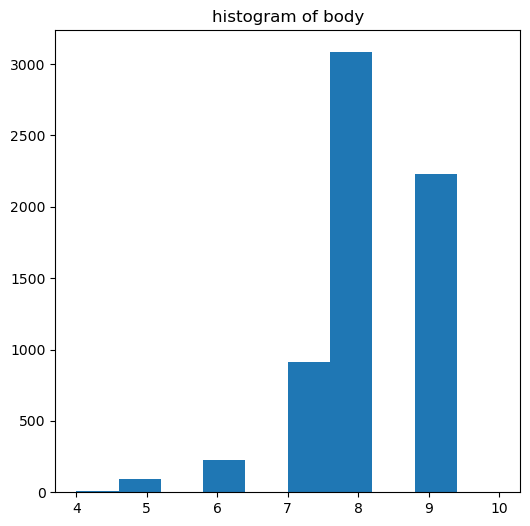

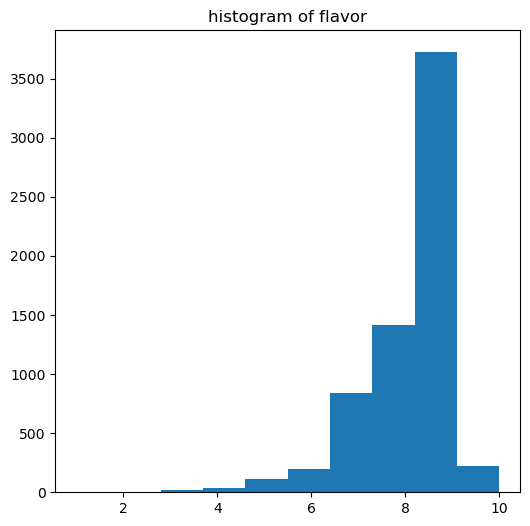

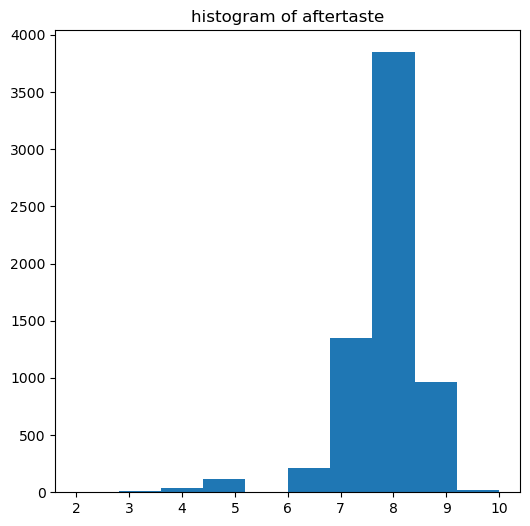

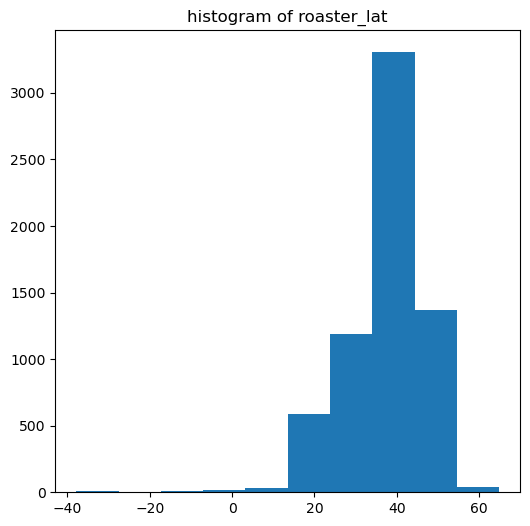

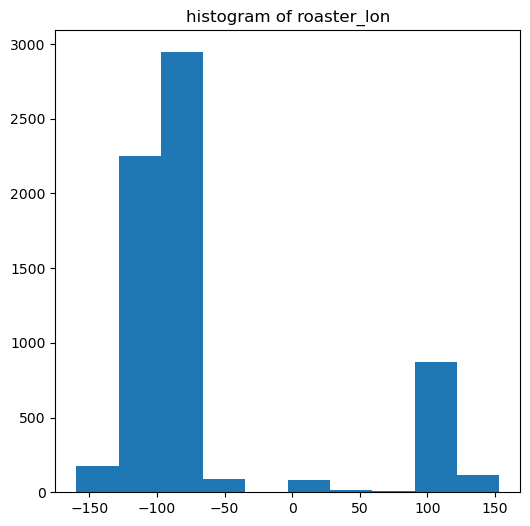

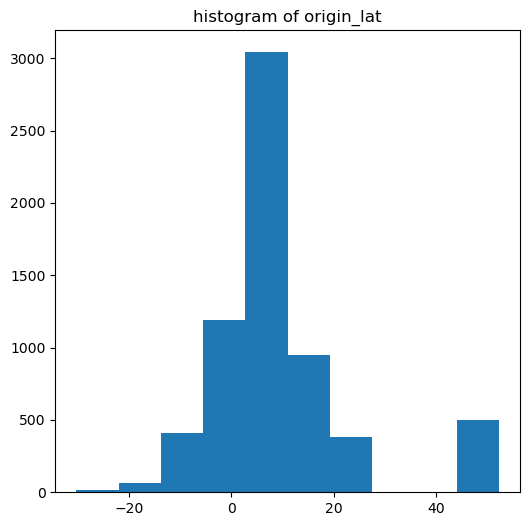

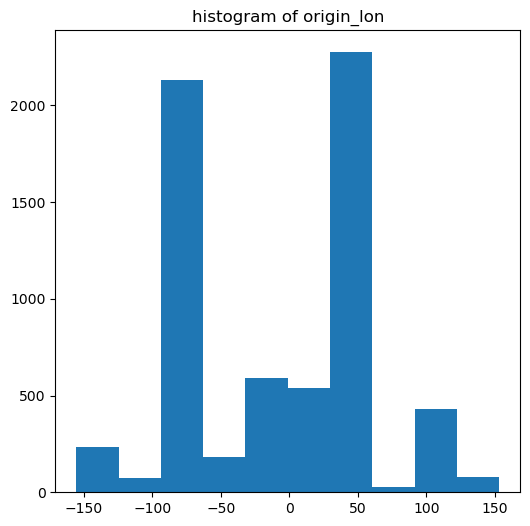

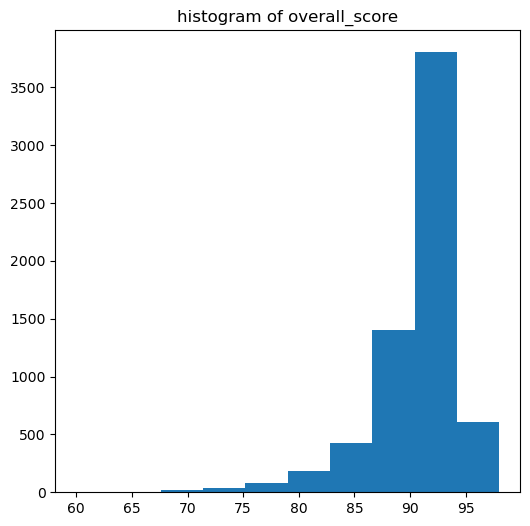

In [9]:
for column in numeric_df.columns:

    plt.figure(figsize = (6,6))
    plt.hist(numeric_df[column])
    plt.title(f"histogram of {column}")
    plt.show()

Commentary on histograms:
- Review month span course of year with spikes in Jan and December
- Number of reviews generally increased year to year
- `bean_agtron` is normally distributed with high number of values between 50 and 60
- `ground_agtron` values are slightly higher on average, with the largest group between 70 and 80
- Subscores for `aroma`, `acidity`, `body`, `flavor`, and `aftertaste` tend to be in higher end of range 0-10
- roasters tend to be in the northern and western hemishere
- coffee tends to originate from the close to the equator in both the western and eastern hemispheres
- `overall_score` (target) tends to be on high end of range 60-100, with most falliing between 90 and 95

### Exploring correlation of values

To get a preliminary sense of the data, creating a heatmap of correlations.

In [53]:
#getting correlations
corr_df = coffee.corr()

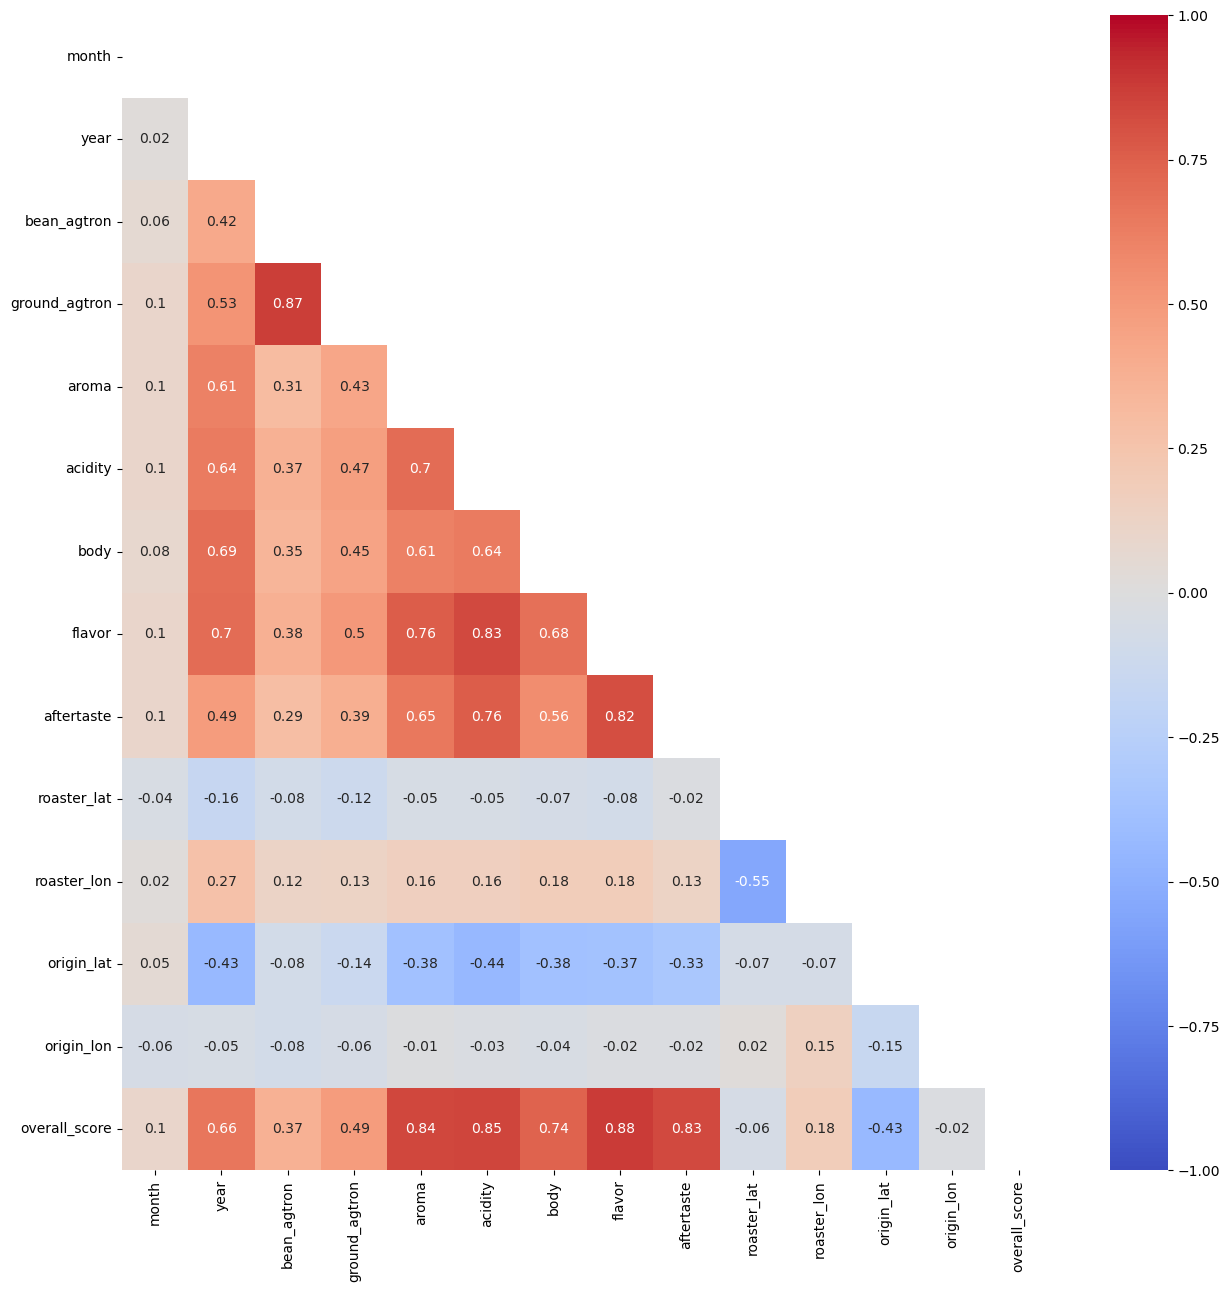

In [57]:
#mapping
mask = np.triu(np.ones_like(corr_df, dtype=bool))

plt.figure(figsize=(15,15))
sns.heatmap(corr_df.round(2), vmax = 1, vmin = -1, center=0, cmap="coolwarm",annot=True, mask=mask)
plt.show()

Commentary of correlations:
- A number of the values are highly correlated with our target `overall_score`, particularly:
    - `year`
    - `aroma`
    - `acidity`
    - `body`
    - `flavor`
    - `aftertaste`

`origin_lat` has a fairly strong inverse relationship with `overall_score`, which could be interesting to dig into further as bean source is a variable that can very practically be controlled.


## Creating X and y values

Given that we can't simply stratefy our train, validation and test splits on a continuous target variable, adding a categorical value corresponding to overall_score. This allows train, val, test to be stratefied, allowing for even distribution of values for training, validation and testing.

In [10]:
score_mapper = {range(0,70):'one', range(70,80):'two', range(80,90):'three', range(90,95):'four', range(95,101):'five'}

In [11]:
numeric_df['overall_cat'] = numeric_df['overall_score'].replace(score_mapper)

In [12]:
numeric_df['overall_cat'].unique()

array(['four', 'five', 'three', 'two', 'one'], dtype=object)

In [14]:
#verifying splits appear accurate
numeric_df[['overall_score', 'overall_cat']].sample(20)

,overall_score,overall_cat
5476,87,three
4996,91,four
4954,88,three
3339,92,four
2097,93,four
1529,93,four
1156,92,four
3974,92,four
2833,93,four
2189,91,four


Establishing features and target. Target is `overall_score`.

In [15]:
X = numeric_df.drop(['overall_score','overall_cat'], axis = 1)

In [16]:
X.shape

(6557, 13)

In [17]:
X.head()

,month,year,bean_agtron,ground_agtron,aroma,acidity,body,flavor,aftertaste,roaster_lat,roaster_lon,origin_lat,origin_lon
0,10,2022,60,77,9,9,9,9,8,37.973535,-122.531087,4.099917,-72.908813
1,10,2022,58,78,9,9,9,9,8,33.448437,-112.074141,-6.869970,-75.045851
2,10,2022,59,77,9,9,8,9,8,33.448437,-112.074141,4.099917,-72.908813
3,10,2022,62,78,8,8,9,9,8,37.973535,-122.531087,12.609016,-85.293691
4,10,2022,65,81,9,9,8,9,8,25.072134,121.679919,10.211670,38.652120


In [18]:
y = numeric_df[['overall_score','overall_cat']]

In [19]:
y.shape

(6557, 2)

In [20]:
#check out target value overview
y.describe()

,overall_score
count,6557.000000
mean,90.873723
std,4.089739
min,60.000000
25%,90.000000
50%,92.000000
75%,93.000000
max,98.000000


Creating train, validate, test splits.

In [21]:
#create train/test split, using 20% given dataset size

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y['overall_cat'], test_size=0.2)

In [23]:
#create train/validate split, using 20% given dataset size

X_remain, X_val, y_remain, y_val = train_test_split(X_train, y_train, stratify = y_train['overall_cat'], test_size=0.2)

In [24]:
#checking out proportions
X_train.shape

(5245, 13)

In [25]:
X_remain.shape

(4196, 13)

In [26]:
X_test.shape

(1312, 13)

In [27]:
X_val.shape

(1049, 13)

In [31]:
y_train.shape

(5245, 2)

In [28]:
y_remain.shape

(4196, 2)

In [29]:
y_val.shape

(1049, 2)

In [30]:
y_test.shape

(1312, 2)

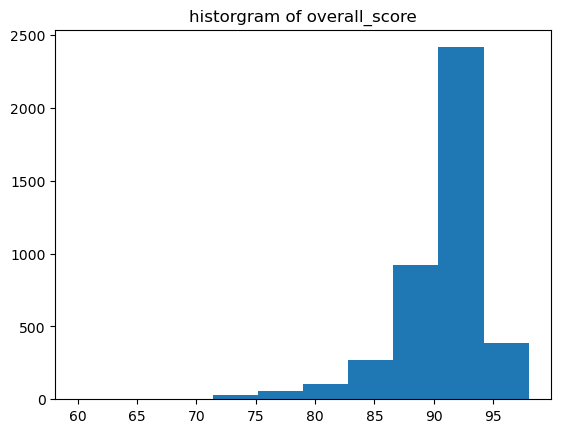

In [32]:
#plot y val distribution
plt.figure()
plt.hist(y_remain['overall_score'])
plt.title('historgram of overall_score')
plt.show()

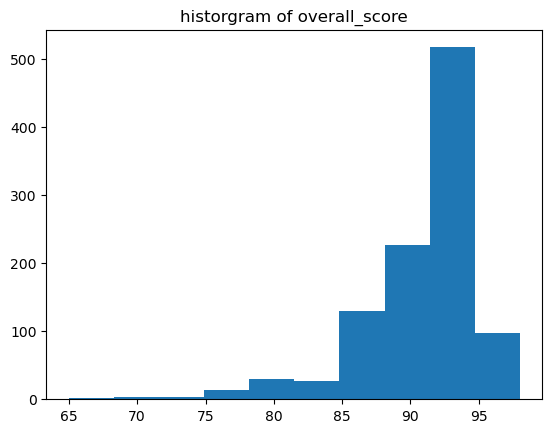

In [35]:
#plot y val distribution
plt.figure()
plt.hist(y_val['overall_score'])
plt.title('historgram of overall_score')
plt.show()

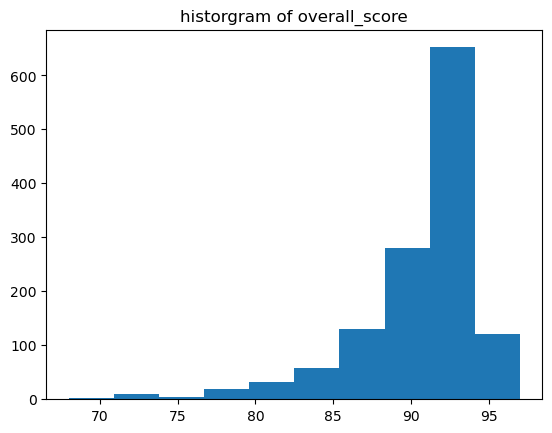

In [36]:
#plot y val distribution
plt.figure()
plt.hist(y_test['overall_score'])
plt.title('historgram of overall_score')
plt.show()

Now that we have evenly distributed splits, we'll drop the categorical column `overall_cat` so that we are just working with our continous targe `overall_score`.

In [37]:
y_train.drop(['overall_cat'], axis = 1, inplace=True)

In [38]:
y_remain.drop(['overall_cat'], axis = 1, inplace=True)

In [39]:
y_val.drop(['overall_cat'], axis = 1, inplace=True)

In [40]:
y_test.drop(['overall_cat'], axis = 1, inplace=True)

In [41]:
y_train.head()

,overall_score
2637,93
3834,94
2069,95
4614,92
4857,90


In [42]:
y_remain.head()

,overall_score
3304,91
3551,92
725,94
356,92
2443,93


In [43]:
y_val.head()

,overall_score
891,93
1344,91
4275,92
5110,90
5286,88


In [44]:
y_test.head()

,overall_score
2076,93
3628,90
5254,89
3167,90
6292,85


## Scaling the data

Scaling is not necessary for all the baseline models we'll be trying here (such as linear regression). However, the data is on different scales, so we'll go ahead and scale now. Testing both MinMax and StandardScaler. We expect MinMax to be the better fit to adjust for distribution of data.

In [45]:
#standard scaling

s_scaler = StandardScaler()
s_scaler.fit(X_remain)
X_s_scaled_remain = s_scaler.transform(X_remain)
X_s_scaled_val = s_scaler.transform(X_val)
X_s_scaled_test = s_scaler.transform(X_test)

In [46]:
#min max scaling

mm_scaler = MinMaxScaler()
mm_scaler.fit(X_remain)
X_mm_scaled_remain = mm_scaler.transform(X_remain)
X_mm_scaled_val = mm_scaler.transform(X_val)
X_mm_scaled_test = mm_scaler.transform(X_test)

## Model 1: Linear Regression 

First vanilla model using **standard scaler** fit on X_scaled_remain.

In [65]:
# 1. Instantiate the model
lr_model_1 = LinearRegression()

# 2. Fit the model
lr_model_1.fit(X_s_scaled_remain, y_remain)

# 3. Scoring the models
print(f'The R2 score for training data is: {lr_model_1.score(X_s_scaled_remain, y_remain)}')

print(f'The R2 score for validation data is: {lr_model_1.score(X_s_scaled_val, y_val)}')

The R2 score for training data is: 0.9057744754192173
The R2 score for validation data is: 0.8995896071990653


Evaluating validation data, uses **min max scaler**:

In [66]:
# 1. Instantiate the model
lr_model_2 = LinearRegression()

# 2. Fit the model
lr_model_2.fit(X_mm_scaled_remain, y_remain)

# 3. Scoring the models
print(f'The R2 score for training data is: {lr_model_2.score(X_mm_scaled_remain, y_remain)}')

print(f'The R2 score for validation data is: {lr_model_2.score(X_mm_scaled_val, y_val)}')

The R2 score for training data is: 0.9057744754192173
The R2 score for validation data is: 0.8995896071990652


Comparing to **non-scaled** data:

In [67]:
# 1. Instantiate the model
lr_model_3 = LinearRegression()

# 2. Fit the model
lr_model_3.fit(X_remain, y_remain)

# 3. Scoring the models
print(f'The R2 score for training data is: {lr_model_3.score(X_remain, y_remain)}')

print(f'The R2 score for validation data is: {lr_model_3.score(X_val, y_val)}')

The R2 score for training data is: 0.9057744754192174
The R2 score for validation data is: 0.8995896071990654


Scaling does not seem to have much impact on our linear regression results. Our baseline linear regression model does a fairly good job predicting the results. 

## Model 2: KNN

For model 2, we'll look at a KNN model.

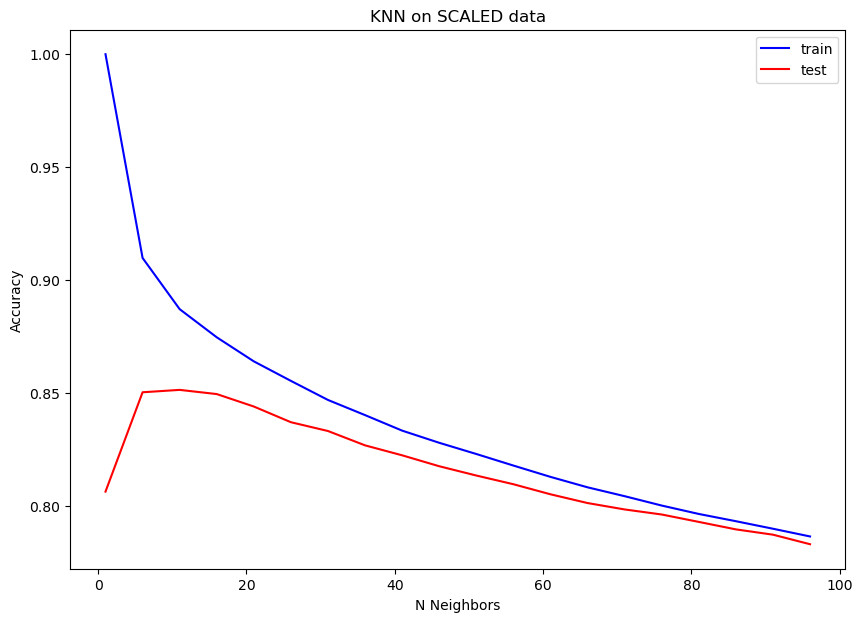

In [75]:
#running across a broad range to see how it performs

k_values = list(range(1,100,5))
train_accs = []
test_accs = []

for k in k_values:
    
    knn_model = KNeighborsRegressor(n_neighbors=k)
    knn_model.fit(X_mm_scaled_remain, y_remain)
    
    train_accs.append(knn_model.score(X_mm_scaled_remain, y_remain))
    test_accs.append(knn_model.score(X_mm_scaled_val, y_val))
    
plt.figure(figsize=(10, 7))
plt.plot(k_values, train_accs, c='blue', label='train')
plt.plot(k_values, test_accs, c='red', label='test')
plt.xlabel('N Neighbors')
plt.ylabel('Accuracy')
plt.title("KNN on SCALED data")
plt.legend()
plt.show()

In [74]:
#running with narrow range and printing scores

k_values = list(range(1,20))
train_accs = []
test_accs = []

for k in k_values:
    
    knn_model = KNeighborsRegressor(n_neighbors=k)
    knn_model.fit(X_mm_scaled_remain, y_remain)
    
    train_accs.append(knn_model.score(X_mm_scaled_remain, y_remain))
    test_accs.append(knn_model.score(X_mm_scaled_val, y_val))
    
    print(f'Neighbor count: {k}')
    print(f'The R2 score for {k} neighbors remaining data is: {knn_model.score(X_mm_scaled_remain, y_remain)}')
    print(f'The R2 score for {k} neighbors validation data is: {knn_model.score(X_mm_scaled_val, y_val)}')

Neighbor count: 1
The R2 score for 1 neighbors remaining data is: 0.9998397751748136
The R2 score for 1 neighbors validation data is: 0.8063541057460769
Neighbor count: 2
The R2 score for 2 neighbors remaining data is: 0.9542303220961934
The R2 score for 2 neighbors validation data is: 0.8259567171098712
Neighbor count: 3
The R2 score for 3 neighbors remaining data is: 0.9355701990841474
The R2 score for 3 neighbors validation data is: 0.8391603989674568
Neighbor count: 4
The R2 score for 4 neighbors remaining data is: 0.9237803223641836
The R2 score for 4 neighbors validation data is: 0.8419171824334629
Neighbor count: 5
The R2 score for 5 neighbors remaining data is: 0.9176193865179036
The R2 score for 5 neighbors validation data is: 0.8486924632306532
Neighbor count: 6
The R2 score for 6 neighbors remaining data is: 0.9097104787504693
The R2 score for 6 neighbors validation data is: 0.8503000080769588
Neighbor count: 7
The R2 score for 7 neighbors remaining data is: 0.90424560169010

Our KNN model works pretty well on the numeric data, although not as well as the linear regression model, with optimal numbers from this basic model around 9 to maximize validation performance and bring down overfitting.

## Model 3: Random Forest

We will also test out a baseline Random Forest model:

In [77]:
# 1. Instantiate the model
rf_model = RandomForestRegressor()

# 2. Fit the model
rf_model.fit(X_mm_scaled_remain, y_remain)

# 3. Scoring the models
print(f'The R2 score for training data is: {rf_model.score(X_mm_scaled_remain, y_remain)}')

print(f'The R2 score for validation data is: {rf_model.score(X_mm_scaled_val, y_val)}')

/var/folders/jm/x73vvhpx2cd14qw0zx2ccfsc0000gn/T/ipykernel_14470/2765553580.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_mm_scaled_remain, y_remain)


The R2 score for training data is: 0.9875910654633459
The R2 score for validation data is: 0.9133856051715658


Out of the box, our Random Forest model is working the best so far.

## Model 4: Support Vector Machine (SVR)

For this model, we will look at Support Vector Regressor:

In [83]:
# 1. Instantiate the model
svr_model = SVR()

# 2. Fit the model
svr_model.fit(X_mm_scaled_remain, y_remain)

# 3. Scoring the models
print(f'The R2 score for training data is: {svr_model.score(X_mm_scaled_remain, y_remain)}')

print(f'The R2 score for validation data is: {svr_model.score(X_mm_scaled_val, y_val)}')

/Users/katemondal/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The R2 score for training data is: 0.9023459133777464
The R2 score for validation data is: 0.8865643223400561


The out of the box SVR does better than KNNs but not as well as Linear Regression or Random Forest.

## Model 5: XG Boost Regressor

For this model, we'll look at XG Boost Regressor:

In [85]:
# 1. Instantiate the model
XGBR_model = XGBRegressor()

# 2. Fit the model
XGBR_model.fit(X_mm_scaled_remain, y_remain)

# 3. Scoring the models
print(f'The R2 score for training data is: {XGBR_model.score(X_mm_scaled_remain, y_remain)}')

print(f'The R2 score for validation data is: {XGBR_model.score(X_mm_scaled_val, y_val)}')

The R2 score for training data is: 0.9918057456853279
The R2 score for validation data is: 0.9174657841098716


Out of the box, the XGBoost Regressor model does well, right up there with Random Forest.

## Model 6: Neural Network

For this last baseline model, we'll build a basic neural network using tensorflow.

In [116]:
# Create a new sequential model
model = keras.Sequential()

# Declare the hidden layers
model.add(layers.Dense(40, activation="relu"))
model.add(layers.Dense(40, activation="relu"))

# Declare the output layer
model.add(layers.Dense(1))

In [117]:
model.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(),  
    # Loss function to minimize
    loss=keras.losses.MeanSquaredError()
)

In [118]:
callback = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 3)

history = model.fit(X_mm_scaled_remain, y_remain, epochs = 200, callbacks=[callback], verbose=1)

Epoch 1/200
132/132 [==============================] - 0s 1ms/step - loss: 5668.1875
Epoch 2/200
132/132 [==============================] - 0s 1ms/step - loss: 106.7060
Epoch 3/200
132/132 [==============================] - 0s 1ms/step - loss: 45.3916
Epoch 4/200
132/132 [==============================] - 0s 1ms/step - loss: 35.3799
Epoch 5/200
132/132 [==============================] - 0s 1ms/step - loss: 26.5048
Epoch 6/200
132/132 [==============================] - 0s 1ms/step - loss: 19.5378
Epoch 7/200
132/132 [==============================] - 0s 2ms/step - loss: 15.7015
Epoch 8/200
132/132 [==============================] - 0s 2ms/step - loss: 13.4620
Epoch 9/200
132/132 [==============================] - 0s 1ms/step - loss: 12.0867
Epoch 10/200
132/132 [==============================] - 0s 2ms/step - loss: 11.0550
Epoch 11/200
132/132 [==============================] - 0s 1ms/step - loss: 10.0635
Epoch 12/200
132/132 [==============================] - 0s 1ms/step - loss: 9.3262

In [ ]:
########### does this make sense for traning lost values?

In [119]:
# Evaluate the model using the test data and generate predictions
train_loss = history.history["loss"][-1]
result = model.evaluate(X_mm_scaled_val, y_val, verbose=0)

print(f"Train Loss: {train_loss:.4f}")
print(f"Val Loss: {result:.4f}")

y_pred = model.predict(X_mm_scaled_val)

Train Loss: 1.6999
Test Loss: 1.9248


In [120]:
r2_score(y_val,y_pred)

0.8895162603335821

This baseline neural network does OK, similar to our SVR. However, there is a lot of customization that can improve the neural network, so it may still be worth exploring the model further.

## Summary of Baseline Model Performance

Below is a summary of R2 scores for each of the models from best to worst:
- XG Boost: R2 .917
- Random Forest: .913
- Linear Regression: .899
- Neural Network: R2 .889
- Support Vector Machines Regressor: R2 of .886
- KNN: R2 .855
